# <div style="text-align: center"> **LABORATORIO 4** 
## **Machine Learning Production Model-Pipeline**
#### Dulce Rocío Sosa Cerna _20000140_

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import joblib

### 1. Cargamos Dataset

In [2]:
data = pd.read_csv('train.csv')

print(str(data.shape) + '\n')

data.head()

(891, 12)



PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

#### Eliminamos columna de id 

In [3]:
data.drop('PassengerId', axis=1, inplace=True)

print(str(data.shape))

(891, 11)


### 2. Análisis de Datos para toma de decisiones en FE Pipeline

### 2.1 Análisis del Taget


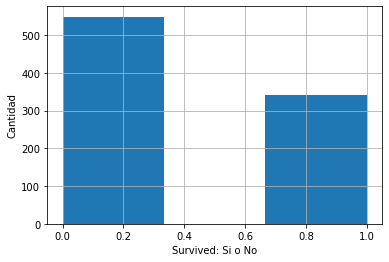

In [4]:
data['Survived'].hist(bins=3, density=False)
plt.xlabel("Survived: Si o No")
plt.ylabel("Cantidad")
plt.show()

### 2.2 Verificamos tipos de variables en X

In [5]:
data.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [6]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']

#Agregamos el caso especial de pclass ya que define el tipo de ticket, por lo tanto, esta variable es categórica 
cat_vars = cat_vars + ['Pclass'] 

In [7]:
#cantidad de varaibles categóricas
len(cat_vars)

6

In [8]:
cat_vars

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass']

In [9]:
#Forzamos a todas las variables como categóticas, incluyendo Pclass
data[cat_vars] = data[cat_vars].astype('O')

In [10]:
data.dtypes

Survived      int64
Pclass       object
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [11]:
#variables numéricas
num_vars = [var for var in data.columns if(var not in cat_vars and var != 'Survived')]

In [12]:
len(num_vars)

4

In [13]:
num_vars

['Age', 'SibSp', 'Parch', 'Fare']

### 2.3 Análisis de Valores Faltantes

In [14]:
var_with_na = [var for var in data.columns if(data[var].isnull().sum() > 0)]
len(var_with_na)

3

In [15]:
#proporcion de NAs en cada variable
data[var_with_na].isnull().mean().sort_values(ascending=False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

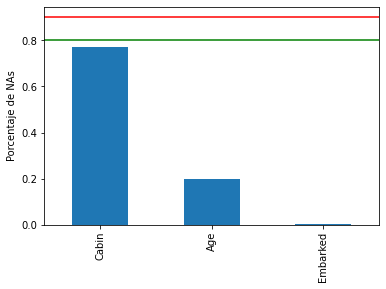

In [16]:
#graficamos porcentajes de NAs.
data[var_with_na].isnull().mean().sort_values(ascending=False).plot.bar()
plt.ylabel("Porcentaje de NAs")
plt.axhline(y=0.9, color="r")
plt.axhline(y=0.8, color="g")

De acuerdo al gráfico anterior, las 3 variables con NAs, son rescatables porque están abajo del 80%.

In [17]:
#variables categóricas con NAs.
cat_na = [var for var in cat_vars if var in var_with_na]
cat_na

['Cabin', 'Embarked']

In [18]:
#variables numéricas con NAs.
num_na = [var for var in num_vars if var in var_with_na]
num_na

['Age']

In [19]:
print("Cantidad de variables numéricas con NAs. {}".format(len(num_na)))
print("Cantidad de variables categóticas con NAs. {}".format(len(cat_na)))

Cantidad de variables numéricas con NAs. 1
Cantidad de variables categóticas con NAs. 2


#### 2.3.1 Verificación del impacto del NA contra el Target (Survived)

In [20]:
df= data.copy()
var= 'Cabin'
df [var]= np.where(df[var].isnull(), 1, 0)
temp = df.groupby(var)['Survived'].agg(['mean', 'std'])

In [21]:
temp

mean       std
Cabin                    
0      0.666667  0.472564
1      0.299854  0.458528

<AxesSubplot:ylabel='Cabin'>

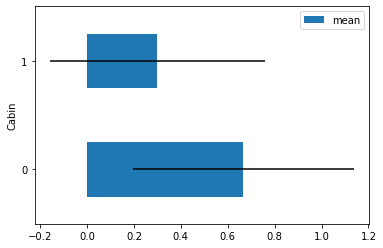

In [22]:
temp.plot(kind="barh", y="mean", xerr="std")

In [23]:
def na_impact_over_target(df, Xvar, Yvar):
    df = data.copy()
    df[Xvar] = np.where(df[Xvar].isnull(), 1, 0)
    temp = df.groupby(Xvar)[Yvar].agg(['mean', 'std'])
    temp.plot(kind="barh", y="mean", xerr="std", legend=False, title=Yvar)
    plt.show()

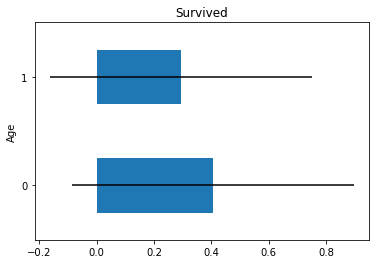

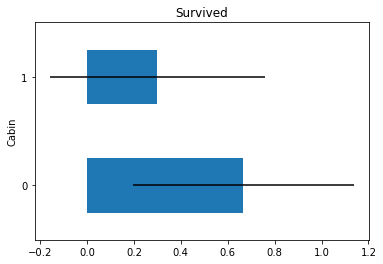

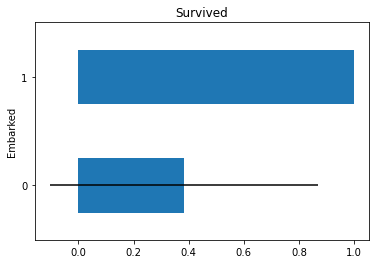

In [24]:
for var in var_with_na:
    na_impact_over_target(data, var, 'Survived')

### 2.4 Análisis de Variables Temporales

In [25]:
year_vars = [var for var in num_vars if (('Yr' in var) or ('Year' in var))]
year_vars

[]

No tenemos variables temporales en la data.

#### Análisis Estadístico

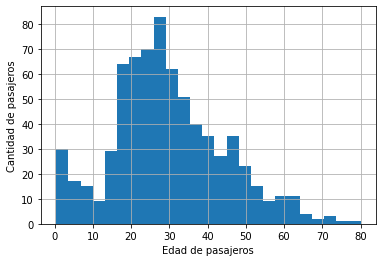

In [26]:
data['Age'].hist(bins=25, density=False)
plt.xlabel("Edad de pasajeros")
plt.ylabel("Cantidad de pasajeros")
plt.show()

El comportamiento de la variable "Age" es bastante normal. La mayoría de edades de la data se encuentran comprendidas entre 15 y 35 años.

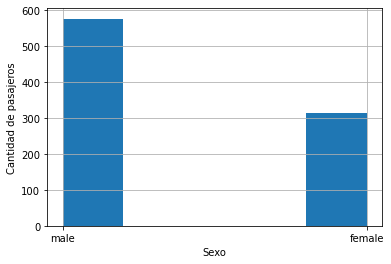

In [27]:
data['Sex'].hist(bins=5, density=False)
plt.xlabel("Sexo")
plt.ylabel("Cantidad de pasajeros")
plt.show()

La mayoría de pasajeros son hombres, aproximadamente 575 versus 300 mujeres.

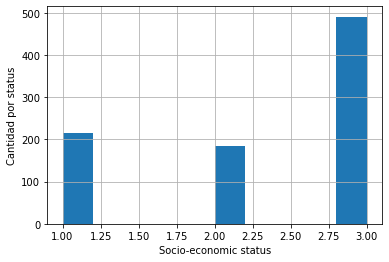

In [28]:
data['Pclass'].hist(bins=10, density=False)
plt.xlabel("Socio-economic status")
plt.ylabel("Cantidad por status")
plt.show()

#1= 1st Upper
#2= 2nd Middle
#3= 3rd Lower

La mayoría de pasajeros se transportaban en clase 3 que era la baja. La clase alta y media presentaron un comportamiento similar.

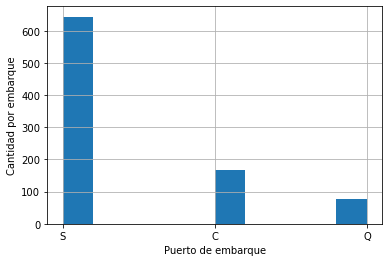

In [29]:
data['Embarked'].hist(bins=10, density=False)
plt.xlabel("Puerto de embarque")
plt.ylabel("Cantidad por embarque")
plt.show()

#C = Cherbourg, Q = Queenstown, S = Southampton

La mayoría de pasajeros embarcaron en el puerto S de "Southampton".

In [30]:
discrete_vars = [var for var in num_vars if((len(data[var].unique()) < 20) and (var not in year_vars))]
discrete_vars

['SibSp', 'Parch']

### 2.5 Variables Discretas

In [31]:
len(data['Age'].unique()) < 20

False

In [32]:
discrete_vars = [var for var in num_vars if((len(data[var].unique()) < 20) and (var not in year_vars))]
discrete_vars

['SibSp', 'Parch']

In [33]:
print("Cantidad de Variables Discretas: ", len(discrete_vars))

Cantidad de Variables Discretas:  2


In [34]:
data[discrete_vars].head()

SibSp  Parch
0      1      0
1      1      0
2      0      0
3      1      0
4      0      0

In [35]:
import seaborn as sns

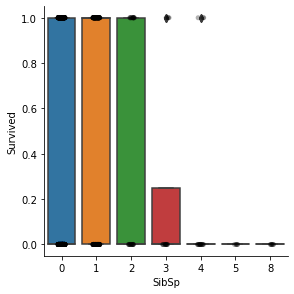

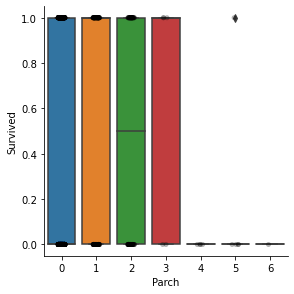

In [36]:
for var in discrete_vars:
    sns.catplot(x=var, y= 'Survived', data=data, kind="box", height=4)
    sns.stripplot(x=var, y='Survived', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()

### 2.6 Variables Continuas

In [37]:
cont_vars = [var for var in num_vars if var not in discrete_vars + year_vars]

In [38]:
print("Variables Numericas Continuas: ", len(cont_vars))

Variables Numericas Continuas:  2


In [39]:
data[cont_vars].head()

Age     Fare
0  22.0   7.2500
1  38.0  71.2833
2  26.0   7.9250
3  35.0  53.1000
4  35.0   8.0500

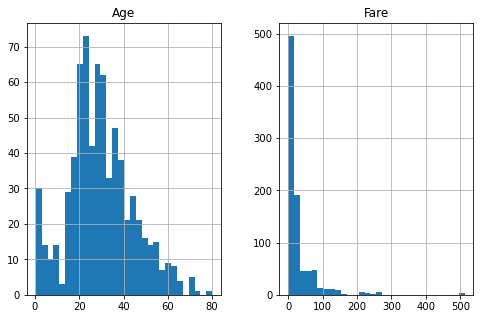

In [40]:
data[cont_vars].hist(bins=30, figsize=(8, 5))
plt.show()

In [41]:
data['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [42]:
#Transformamos NaN de Age por 0.
data['Age'] = data['Age'].replace('nan', np.nan).fillna(0)

In [43]:
data['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     0.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [44]:
sesgadas = []

In [45]:
cont_vars = [var for var in cont_vars if var not in sesgadas]

In [46]:
cont_vars

['Age', 'Fare']

**Las variables no presentan un sesgo prolongado, por lo tanto no aplicaremos transformación**

C:\Users\Kemik\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


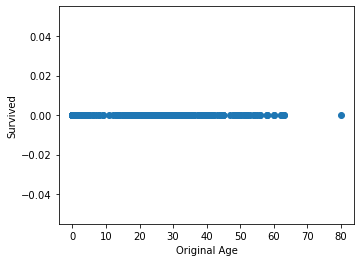

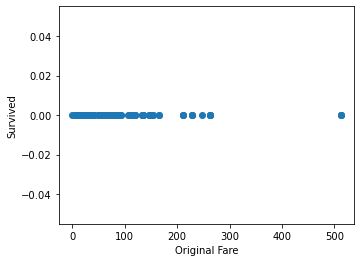

In [47]:
for var in cont_vars:
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data[var], np.log(data['Survived']))
    plt.ylabel("Survived")
    plt.xlabel("Original " + var)

    plt.show()

In [48]:
for var in sesgadas:
    temp = data.copy()
    
    temp[var] = np.where(data[var] == 0, 0, 1)
    
    temp = temp.groupby(var)['Survived'].agg(['mean', 'std'])
    
    temp.plot(kind='barh', y="mean", legend=False, xerr="std", title = "Survived", color="green")
    plt.show()

### 2.7 Variables Categóricas

In [49]:
len(cat_vars)

6

In [50]:
data[cat_vars].head()

Name     Sex  \
0                            Braund, Mr. Owen Harris    male   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
2                             Heikkinen, Miss. Laina  female   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
4                           Allen, Mr. William Henry    male   

             Ticket Cabin Embarked Pclass  
0         A/5 21171   NaN        S      3  
1          PC 17599   C85        C      1  
2  STON/O2. 3101282   NaN        S      3  
3            113803  C123        S      1  
4            373450   NaN        S      3

<AxesSubplot:>

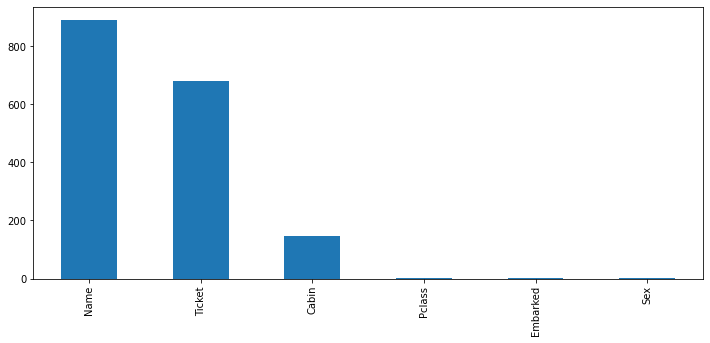

In [51]:
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [52]:
data['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [53]:
data['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [54]:
data['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [55]:
np.unique(data['Pclass'])

array([1, 2, 3], dtype=object)

In [56]:
data['Embarked']

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [57]:
np.unique(data['Sex'])

array(['female', 'male'], dtype=object)

##### Transformando variables categóricas

In [58]:
embarked_mapping = {'S':1, 'C':2, 'Q':3, 'Missing':0, 'NA':0, 'NaN':0}

In [59]:
embarked_var = ['Embarked']

In [60]:
for var in embarked_var:
    data[var] = data[var].map(embarked_mapping)

In [61]:
data[embarked_var].head()

Embarked
0       1.0
1       2.0
2       1.0
3       1.0
4       1.0

In [62]:
data['Cabin'] = data['Cabin'].replace('nan', np.nan).fillna(0)

In [63]:
data['Cabin']

0         0
1       C85
2         0
3      C123
4         0
       ... 
886       0
887     B42
888       0
889    C148
890       0
Name: Cabin, Length: 891, dtype: object

In [64]:
transfor_vars = embarked_var

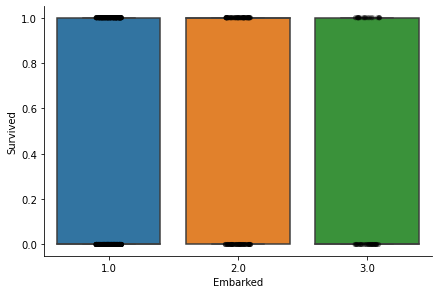

In [65]:
for var in transfor_vars:
    sns.catplot(x=var, y = 'Survived', data=data, kind="box", height=4, aspect=1.5)
    sns.stripplot(x=var, y='Survived', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()

In [66]:
otras = [var for var in cat_vars if var not in transfor_vars]

In [67]:
len(otras)

5

### 2.8 Rare Labels

In [68]:
def analyse_rare_labels(df, var, rare_perc):
    temp = df.groupby(var)['Survived'].count()/len(df)
    
    return temp[temp < rare_perc]

In [69]:
for var in otras:
    print(analyse_rare_labels(data, var, 0.01))
    print()

Name
Abbing, Mr. Anthony                      0.001122
Abbott, Mr. Rossmore Edward              0.001122
Abbott, Mrs. Stanton (Rosa Hunt)         0.001122
Abelson, Mr. Samuel                      0.001122
Abelson, Mrs. Samuel (Hannah Wizosky)    0.001122
                                           ...   
de Mulder, Mr. Theodore                  0.001122
de Pelsmaeker, Mr. Alfons                0.001122
del Carlo, Mr. Sebastiano                0.001122
van Billiard, Mr. Austin Blyler          0.001122
van Melkebeke, Mr. Philemon              0.001122
Name: Survived, Length: 891, dtype: float64

Series([], Name: Survived, dtype: float64)

Ticket
110152         0.003367
110413         0.003367
110465         0.002245
110564         0.001122
110813         0.001122
                 ...   
W./C. 6608     0.004489
W./C. 6609     0.001122
W.E.P. 5734    0.001122
W/C 14208      0.001122
WE/P 5735      0.002245
Name: Survived, Length: 681, dtype: float64

Cabin
A10    0.001122
A14    0.001122
A1

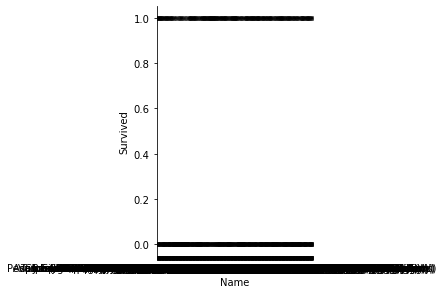

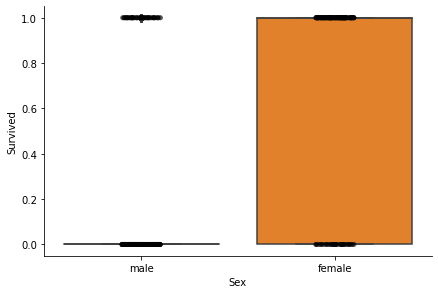

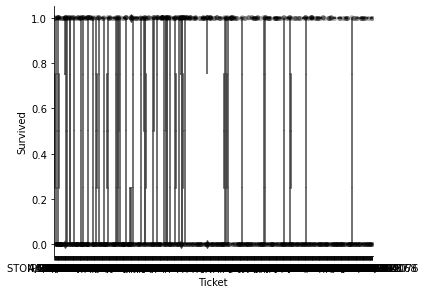

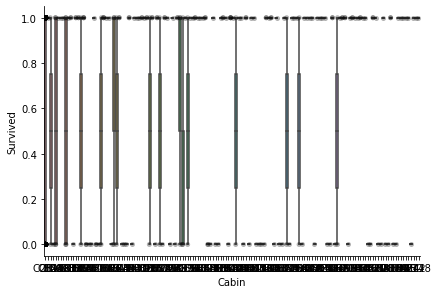

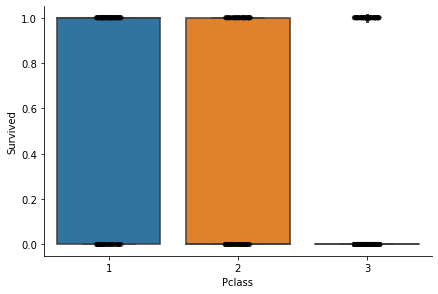

In [70]:
for var in otras:
    sns.catplot(x=var, y = 'Survived', data=data, kind="box", height=4, aspect=1.5)
    sns.stripplot(x=var, y='Survived', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()

#### Aparecen como etiquetas raras "Name", "Ticket" y "Cabin", por el tipo de información que contienen, sin embargo, no necesita transformación

In [72]:
pd.pandas.set_option('display.max_columns', None) #habilitamos despliegue maximo de columnas

In [73]:
data = pd.read_csv('train.csv')
print(data.shape)

(891, 12)


In [74]:
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [75]:
#separamos data para entrenamiento y prueba,
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(['PassengerId', 'Survived'], axis=1),
                        data['Survived'],
                        test_size=0.15,
                        random_state=2021)

In [76]:
X_train.shape, X_test.shape

((757, 10), (134, 10))

### 2.9 Transformación del Target a Gausssiano

In [79]:
y_train = np.log(y_train)
y_test = np.log(y_test)

### 2.10 Missing Values

#### 2.10.1 Missing Values para Variables Categóricas

In [80]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars = cat_vars + ['Pclass']

In [81]:
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

In [82]:
len(cat_vars)

6

##### 2.10.1.1 Detección de NaN en variables categórias

In [84]:
cat_vars_with_na = [var for var in cat_vars 
                        if X_train[var].isnull().sum() > 0]

In [85]:
cat_vars_with_na

['Cabin', 'Embarked']

In [86]:
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending = False)

Cabin       0.764861
Embarked    0.001321
dtype: float64

In [87]:
#variables tratadas con etiqueta de faltante por cantidad masiva de faltantes.
vars_with_missing_string = [var for var in cat_vars_with_na
                               if X_train[var].isnull().mean() > 0.2]

#variables tratadas con procedimiento por candiad adecuada de faltantes.
vars_freq_category = [var for var in cat_vars_with_na
                               if X_train[var].isnull().mean() <= 0.2]

In [88]:
vars_with_missing_string

['Cabin']

In [89]:
vars_freq_category

['Embarked']

In [90]:
#Aplicamos criterio para tratar data faltante

#Faltantes con etiqueta missing
X_train[vars_with_missing_string] = X_train[vars_with_missing_string].fillna('Missing')
X_test[vars_with_missing_string] = X_test[vars_with_missing_string].fillna('Missing')

In [91]:
for var in vars_freq_category:
    mode = X_train[var].mode()[0]
    
    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)
    
    print(var, "-------", mode)

Embarked ------- S


In [92]:
X_train['Embarked'].mode()[0]

'S'

In [93]:
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending = False)

Embarked    0.0
Cabin       0.0
dtype: float64

In [94]:
cat_vars_with_na = [var for var in cat_vars 
                        if X_train[var].isnull().sum() > 0]
cat_vars_with_na

[]

#### 2.10.2 Missing Values para Variables Numéricas

In [95]:
num_vars = [var for var in X_train.columns
               if var not in cat_vars and var != 'Survived']

In [96]:
len(num_vars)

4

In [97]:
##Numéricas con faltantes
num_vars_with_na = [var for var in num_vars
                       if X_train[var].isnull().sum() > 0]

In [98]:
X_train[num_vars_with_na].isnull().mean()

Age    0.200793
dtype: float64

In [99]:
#Aplicamos criterio para data faltante

for var in num_vars_with_na:
    mean_val = X_train[var].mean()
    
    print(var, mean_val)
    
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

Age 29.51267768595041


In [100]:
X_train[num_vars_with_na].isnull().mean()

Age    0.0
dtype: float64

### 2.11 Variables Temporales

In [102]:
def elapsed_time(df, var, ref):
    df[var] = df[ref] - df[var]
    return df

In [103]:
year_vars = [var for var in num_vars if (('Yr' in var) or ('Year' in var))]
year_vars

[]

#### No tenemos variables temporales

### 2.12 Transformación de Variables Numéricas

In [106]:
#Aplicamos transformación logaritmica para variables Age
for var in ['Age']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

In [108]:
#aplicamos transoformación de Yeo-Jonhson
X_train['Fare'], param = stats.yeojohnson(X_train['Fare'])

In [109]:
X_test['Fare'] = stats.yeojohnson(X_test['Fare'], lmbda=param)

In [110]:
print(param)

0.06251441763868533


#### 2.12.1 Binarización de Variables con Sesgo fuerte

In [111]:
sesgadas = []

In [112]:
for var in sesgadas:
    X_train[var] = np.where(X_train[var] == 0, 0, 1)
    X_test[var] = np.where(X_test[var] == 0, 0, 1)

#### No se tienen variables con sesgo

### 2.13 Codificación de Variables Categóricas

In [114]:
#mapeo ordinal de categorías de calidad

embarked_mapping = {'S':1, 'C':2, 'Q':3, 'Missing':0, 'NA':0, 'NaN':0}
embarked_var = ['Embarked']

for var in embarked_var:
    X_train[var] = X_train[var].map(embarked_mapping)
    X_test[var] = X_test[var].map(embarked_mapping)

In [116]:
sex_mapping= {'female': 1, 'male': 2}
sex_var = ['Sex']

for var in sex_var:
    X_train[var] = X_train[var].map(sex_mapping)
    X_test[var] = X_test[var].map(sex_mapping)

In [127]:
pclass_mapping= {'1': 1, '2': 2, '3': 3}
pclass_var = ['Pclass']

for var in pclass_var:
    X_train[var] = X_train[var].map(pclass_mapping)
    X_test[var] = X_test[var].map(pclass_mapping)

In [128]:
cods_vars = embarked_var + sex_var + pclass_var

In [129]:
other_cat = [var for var in cat_vars if var not in cods_vars]

In [130]:
other_cat

['Name', 'Ticket', 'Cabin']

In [131]:
len(other_cat)

3

In [132]:
#funcion para encontar etiquetas raras
def find_rare_labels_freq(df, var, rare_perc):
    temp = df.groupby(var)[var].count()/len(df)
    return temp[temp > rare_perc].index

In [133]:
for var in other_cat:
    freqValue = find_rare_labels_freq(X_train, var, 0.01)
    
    #print(var, '--------', freqValue)
    
    X_train[var] = np.where(X_train[var].isin(freqValue), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(freqValue), X_test[var], 'Rare')

In [134]:
def replace_category_vals(train, test, y_train, var, target):
    
    temp = pd.concat([train, y_train], axis=1) 
    order_labels = temp.groupby([var])[target].mean().sort_values().index
    
    ordinal_values = {k: i for i, k in enumerate(order_labels, 0)}
    
    print(var, ordinal_values)
    
    train[var] = train[var].map(ordinal_values)
    test[var] = test[var].map(ordinal_values)

In [135]:
for var in other_cat:
    replace_category_vals(X_train, X_test, y_train, var, 'Survived')

Name {'0': 0}
Ticket {'0': 0}
Cabin {'0': 0, '1': 1}


In [136]:
def analyse_other_cats(train, y_train, var):
    temp = pd.concat([train, y_train], axis=1)

    temp.groupby(var)['Survived'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Cantidad')
    plt.show()

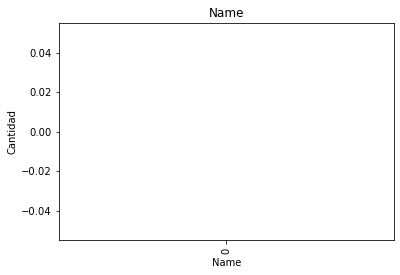

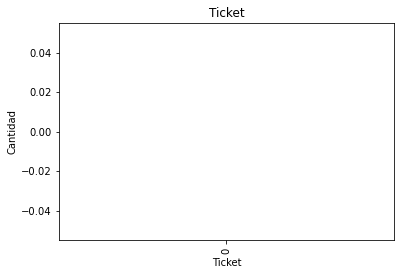

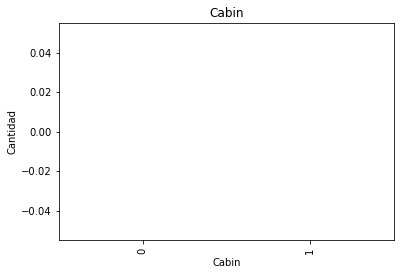

In [137]:
for var in other_cat:
    analyse_other_cats(X_train, y_train, var)

### 2.14 Feature Scaling

In [182]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)


X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

C:\Users\Kemik\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Kemik\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [183]:
X_train.head()

Pclass  Name  Sex       Age  SibSp     Parch  Ticket      Fare  Cabin  \
0     NaN   0.0  0.0  0.963651  0.125  0.166667     0.0  0.857062    0.0   
1     NaN   0.0  1.0  0.914976  0.125  0.333333     0.0  0.665308    0.0   
2     NaN   0.0  1.0  0.930261  0.000  0.000000     0.0  0.397931    0.0   
3     NaN   0.0  0.0  0.792383  0.000  0.333333     0.0  0.582527    0.0   
4     NaN   0.0  0.0  0.865385  0.000  0.000000     0.0  0.391038    0.0   

   Embarked  
0       0.0  
1       0.5  
2       0.0  
3       0.0  
4       1.0

In [184]:
#Guardamos dataset con data preparada para entrenamiento.

X_train.to_csv('preprocess_data/prep_Xtrain.csv', index=False)
X_test.to_csv('preprocess_data/prep_Xtest.csv', index=False)

y_train.to_csv('preprocess_data/prep_ytrain', index=False)
y_test.to_csv('preprocess_data/prep_ytest', index=False)

In [185]:
joblib.dump(scaler, 'preprocess_data/minmax_scaler.joblib')

['preprocess_data/minmax_scaler.joblib']

In [186]:
np.sum(X_train[X_train == 'S'].sum(axis=0))

0.0

### 2.15 Selección de variables

In [187]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel